# Faiss 라이브러리를 활용한 유사한 이미지 검색 알고리즘

In [20]:
import cv2
import numpy as np
import faiss
from glob import glob
import matplotlib.pyplot as plt

### 1. 이미지 특징 추출 및 데이터베이스 생성

In [99]:
import cv2, os
import numpy as np
import faiss
from glob import glob
from pathlib import Path

def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# 이미지 데이터베이스 생성
database_dir = './database/'
manufacturer_list = glob(database_dir + "*")

database_images = []
for manufacturer in manufacturer_list:
    for root, dirs, files in os.walk(str(database_dir)):
        for file in files:
            database_images.append(os.path.join(root, file))

database_features = []

for image_path in database_images:
    print(image_path)
    image = cv2.imread(image_path)
    hist = extract_color_histogram(image)
    database_features.append(hist)

database_features = np.array(database_features)
np.save('database_features.npy', database_features)

./database/hyundai\casper\hyundai+casper_16925963501f6e1d00.jpg
./database/hyundai\casper\hyundai+casper_169259635027c669b9.jpg
./database/hyundai\casper\hyundai+casper_16925963505663076e.jpg
./database/hyundai\casper\hyundai+casper_169259635071c8a6ad.jpg
./database/hyundai\casper\hyundai+casper_1692596350bde41f0e.jpg
./database/hyundai\casper\hyundai+casper_169259635108f70a8d.jpg
./database/hyundai\casper\hyundai+casper_16925963512634d4a8.jpg
./database/hyundai\casper\hyundai+casper_1692596351269f5f10.jpg
./database/hyundai\casper\hyundai+casper_16925963518f07b807.jpg
./database/hyundai\casper\hyundai+casper_1692596351a99282c0.jpg
./database/hyundai\casper\hyundai+casper_169259635215b2eb73.jpg
./database/hyundai\casper\hyundai+casper_16925963526332a773.jpg
./database/hyundai\casper\hyundai+casper_16925963527866bd80.jpg
./database/hyundai\casper\hyundai+casper_1692596352c7d33537.jpg
./database/hyundai\casper\hyundai+casper_1692596352cdf05715.jpg
./database/hyundai\casper\hyundai+casper

### 2. Faiss 인덱스 빌드 및 이미지 검색

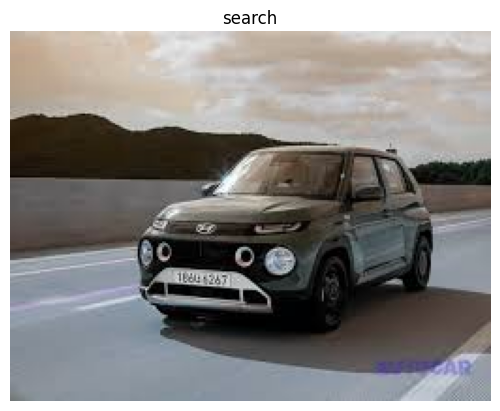

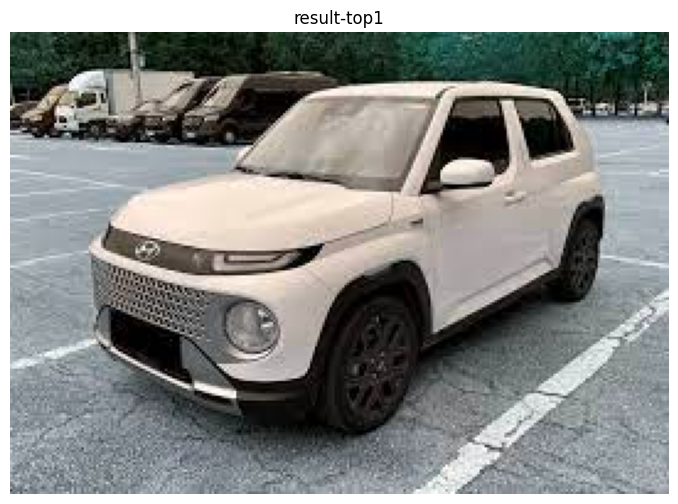

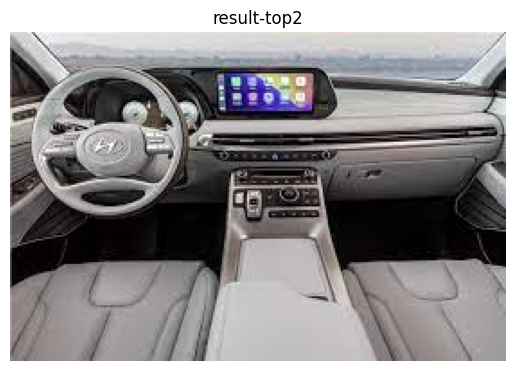

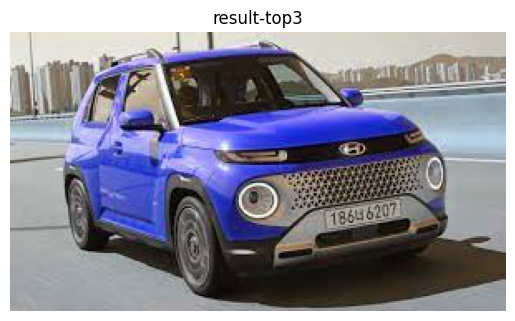

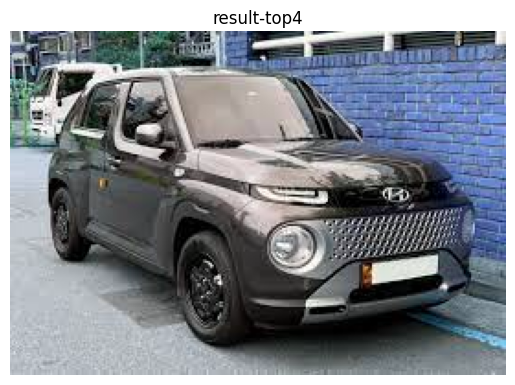

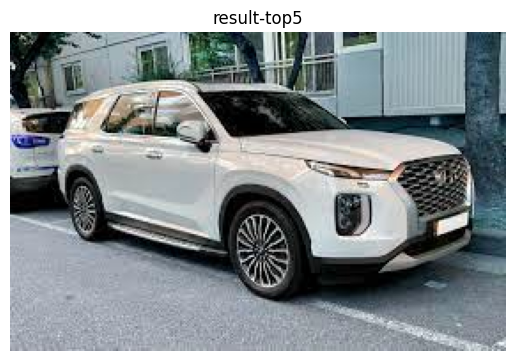

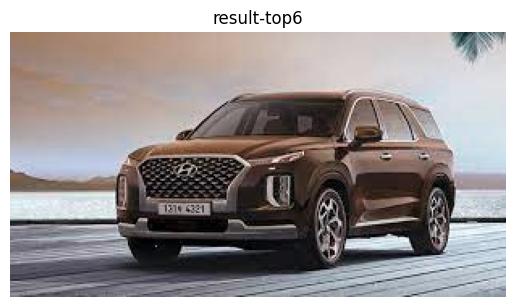

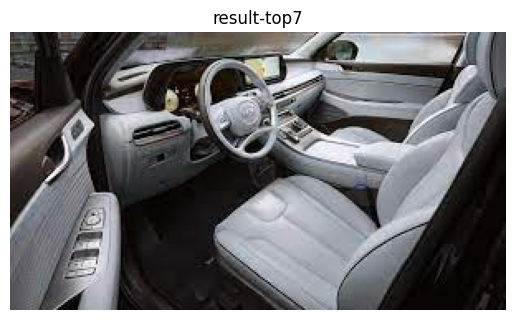

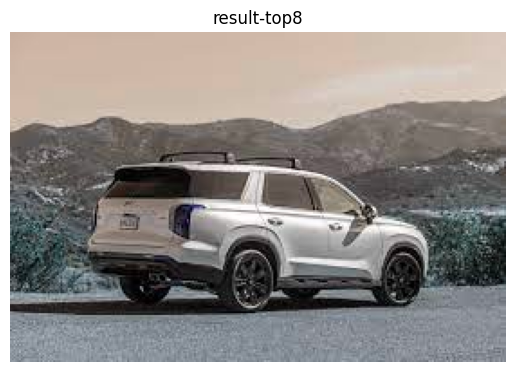

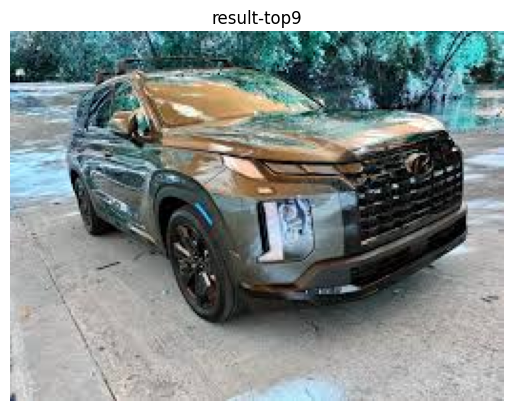

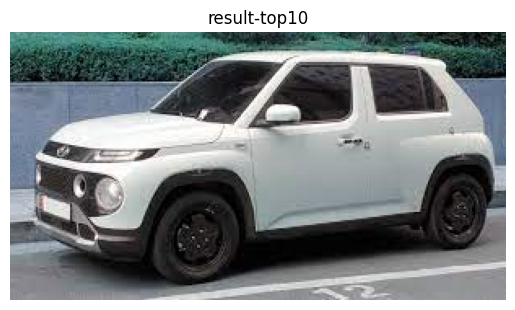

In [102]:
# 데이터베이스 특징 로드
database_features = np.load('database_features.npy')

# Faiss 인덱스 빌드
index = faiss.IndexFlatL2(database_features.shape[1])
index.add(database_features)

# 검색할 이미지 특징 추출
query_image = cv2.imread('./img/images.jfif')
query_hist = extract_color_histogram(query_image)

# 검색
query_hist = np.array([query_hist])
_, indices = index.search(query_hist, k=10)  # 상위 3개 이미지 검색

plt.imshow(query_image), plt.axis("off"), plt.title("search")
plt.show()

# print("검색 결과:")
plt.figure(figsize=(20,6))
for i, index in enumerate(indices[0]):
    # print(f"Rank {i+1}: Image Index = {index}")
    result_image_path = database_images[index]
    result_image = cv2.imread(result_image_path)
    plt.imshow(result_image), plt.axis("off"), plt.title(f"result-top{i+1}")
    plt.show()
    

